In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#import pyemma
from shapeGMM import gmm_shapes
from shapeGMMTorch import torch_sgmm
from shapeGMMTorch import scripts
import MDAnalysis as md
import torch
import pickle

In [2]:
# read trajectory data
data_path = "../md_sims_aib9"
backbone_selection_101 = "(name C and resid 1) or (name C CA N and not resid 1 9) or (name N and resid 9)"
print("selected atoms:", backbone_selection_101)

# load data
prmtopFileName =  data_path + "/right/right.gro"
trajFiles = [data_path+"/left/aib9_left_20ns_wrapped.xtc", data_path+"/right/aib9_right_20ns_wrapped.xtc"]
print(trajFiles)
print(len(trajFiles))

coord = md.Universe(prmtopFileName,trajFiles)
sel_backbone_101 = coord.select_atoms(backbone_selection_101)
print("Number of atoms in trajectory:", coord.atoms.n_atoms)
print("Number of frames in trajectory:",coord.trajectory.n_frames)
print("Number of atoms being analyzed:",sel_backbone_101.n_atoms)
print("Number of frames being analyzed:",coord.trajectory.n_frames)

trajData = np.empty((coord.trajectory.n_frames,sel_backbone_101.n_atoms,3),dtype=float)
count = 0

for ts in coord.trajectory:
    trajData[count,:,:] = sel_backbone_101.positions - sel_backbone_101.center_of_geometry()
    count += 1

selected atoms: (name C and resid 1) or (name C CA N and not resid 1 9) or (name N and resid 9)
['../md_sims_aib9/left/aib9_left_20ns_wrapped.xtc', '../md_sims_aib9/right/aib9_right_20ns_wrapped.xtc']
2
Number of atoms in trajectory: 4749
Number of frames in trajectory: 40002
Number of atoms being analyzed: 23
Number of frames being analyzed: 40002


# Perform Cross Validation Cluster Scan (can take a while)

In [3]:
# define cluster array
cluster_array = np.arange(2,8,1).astype(int)
print(cluster_array)

[2 3 4 5 6 7]


In [4]:
# load data
weighted_train_log_lik = np.loadtxt("weighted_train_2_7.dat")[:,1:]
weighted_predict_log_lik = np.loadtxt("weighted_predict_2_7.dat")[:,1:]

In [5]:
print("weighted_train_log_lik:\n", weighted_train_log_lik, '\n')
print("weighted_predict_log_lik:\n", weighted_predict_log_lik)

weighted_train_log_lik:
 [[108.4622463  108.27225689 108.17712373 108.35454856 108.61558073]
 [114.48715081 114.47579674 114.29145692 114.4989226  114.12706935]
 [115.98466055 115.97720142 115.89162694 116.06799503 116.12687764]
 [117.17377792 116.91187067 116.62539721 116.97539982 117.08191831]
 [117.73029649 117.67049295 117.57376609 117.64855213 118.02601621]
 [118.22229951 118.40662356 118.35352265 118.22669708 118.37417462]] 

weighted_predict_log_lik:
 [[108.22475732 108.42339203 108.51492993 108.34307017 108.07611551]
 [114.42040628 114.48501588 114.64532519 114.4766607  113.7891826 ]
 [115.930094   115.91714267 116.1253715  115.95853471 115.72456231]
 [117.1146732  116.85993096 116.81641142 116.81521929 116.70604181]
 [117.65968766 117.58795575 117.63932634 117.45138048 117.68652259]
 [118.13661511 118.34319663 118.37861922 118.01719924 117.9818755 ]]


# Make Log Likelihood vs number of Cluster Plots

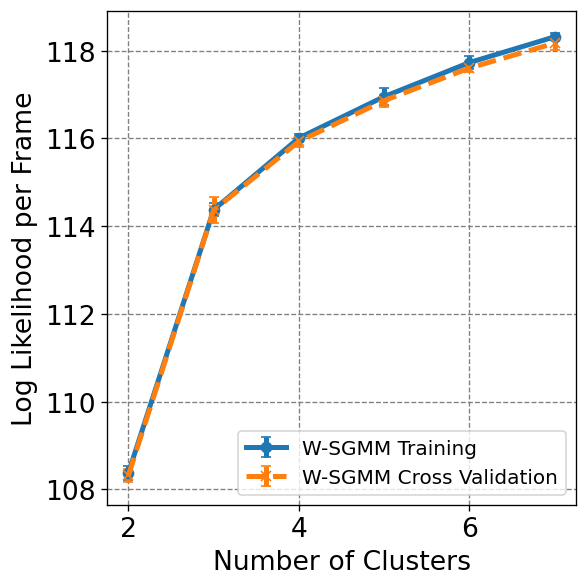

In [13]:
# create figure
plt.figure(figsize=(5,5), dpi= 120, facecolor='w', edgecolor='k')
# weighted SGMM
weighted_train_mean = np.mean(weighted_train_log_lik,axis=1)
weighted_train_std = np.std(weighted_train_log_lik,axis=1)
plt.errorbar(cluster_array,weighted_train_mean,weighted_train_std,fmt='-o',lw=3,capsize=3,label="W-SGMM Training")
#lower, upper = pyemma.util.statistics.confidence_interval((weighted_train_log_lik).T.tolist(), conf=0.9)
#plt.fill_between(cluster_array, lower, upper, alpha=0.3)
weighted_predict_mean = np.mean(weighted_predict_log_lik,axis=1)
weighted_predict_std = np.std(weighted_predict_log_lik,axis=1)
plt.errorbar(cluster_array,weighted_predict_mean,weighted_predict_std,fmt='--x',lw=3,capsize=3,label="W-SGMM Cross Validation")
#lower, upper = pyemma.util.statistics.confidence_interval((weighted_predict_log_lik).T.tolist(), conf=0.9)
#plt.fill_between(cluster_array, lower, upper, alpha=0.3)
plt.grid(which='major', axis='both', color='#808080', linestyle='--')
plt.ylabel("Log Likelihood per Frame",fontsize=16)
plt.xlabel("Number of Clusters",fontsize=16)
plt.tick_params(axis='both',labelsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.tight_layout()
plt.savefig("aib9_log_likelihood_cv.png",dpi=300,transparent=True)

# Run WSGMM for nClusters=3

In [8]:
with open("wsgmm.pickle", "rb")as f_o:
    wsgmm = pickle.load(f_o)

In [9]:
print("lpdets = ", wsgmm.lpdets)
print("det(covs) = ", np.exp(wsgmm.lpdets))

lpdets =  [-103.06697094 -103.53150077  -75.39172674]
det(covs) =  [1.73214104e-45 1.08853027e-45 1.81046067e-33]


In [10]:
# check cluster populations
print(wsgmm.weights)

[0.45545148 0.39059709 0.15395143]


In [ ]:
#predict if you didn't train on entire data set
entire_traj_clusters, entire_traj_traj, entire_traj_log_lik = wsgmm.predict(trajData)

In [ ]:
print(entire_traj_clusters.shape)
print(entire_traj_traj.shape)
print(entire_traj_log_lik)

In [11]:
entire_traj_clusters = np.loadtxt("clusters.txt")

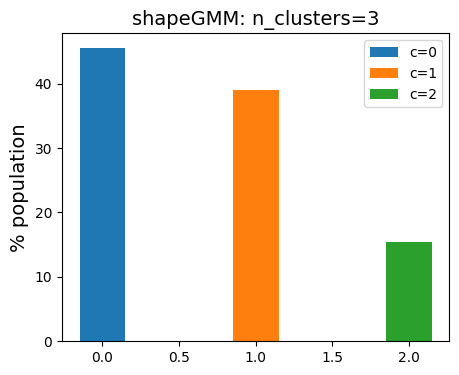

In [12]:
vals, counts = np.unique(entire_traj_clusters, return_counts=True)

plt.figure(figsize=(5,4), dpi=100)
plt.title("shapeGMM: n_clusters=3", fontsize=14)
plt.ylabel("% population", fontsize=14)
for i in range(3):
    plt.bar(vals[i], counts[i]*100/np.sum(counts), width=0.3, label="c=%d"%i)
plt.legend()
plt.savefig("cluster_population.pdf", format="pdf")

# Make 2D FE Plot with clusterings

In [14]:
from shapeGMM._traj_tools import weight_kabsch_dist_align

In [15]:
delta=1

In [16]:
mahaClusterCenters = np.empty((trajData[::delta].shape[0],2),dtype=np.float32)
for frame in range(trajData[::delta].shape[0]):
    mahaClusterCenters[frame,0] = np.sqrt(weight_kabsch_dist_align(trajData[::delta][frame].astype(np.float64),wsgmm.centers[0].astype(np.float64),wsgmm.precisions[0]))
    mahaClusterCenters[frame,1] = np.sqrt(weight_kabsch_dist_align(trajData[::delta][frame].astype(np.float64),wsgmm.centers[1].astype(np.float64),wsgmm.precisions[1]))

In [17]:
print(wsgmm.clusters.shape) #! 1 less that #tot_frames

(40001,)


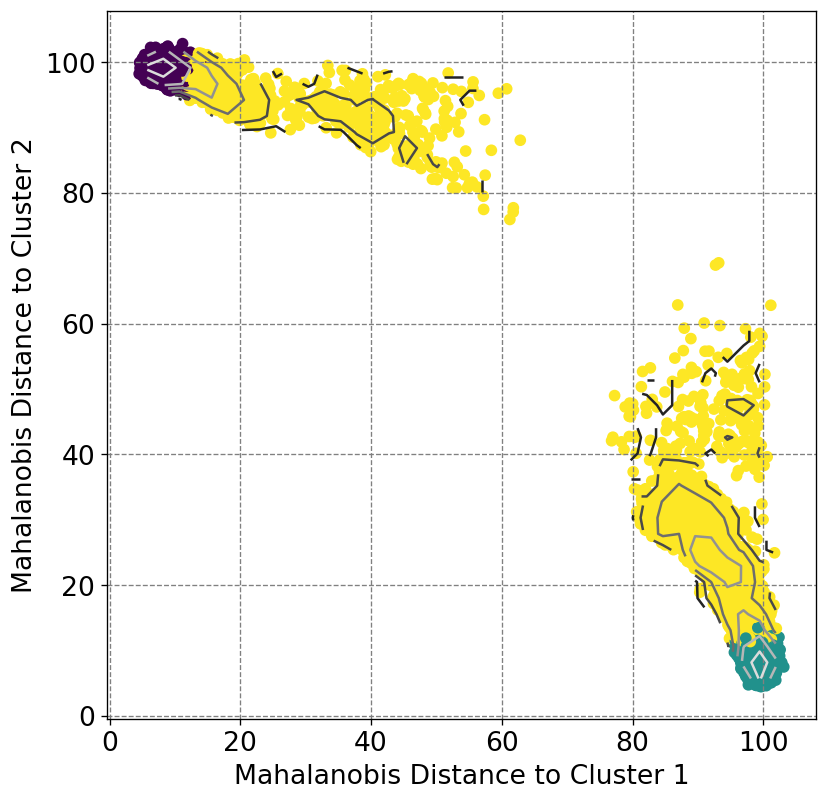

In [19]:
plt.figure(figsize=(7,7), dpi= 120, facecolor='w', edgecolor='k')
x = mahaClusterCenters[:,0]
y = mahaClusterCenters[:,1]
H, xedges, yedges = np.histogram2d(x,y,bins=40,density=True)
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
H = -np.log(H.T)
xx, yy = np.meshgrid(xcenters, ycenters)
plt.contour(xx,yy,H,cmap='binary')
plt.ylabel("Mahalanobis Distance to Cluster 2",fontsize=16)
plt.xlabel("Mahalanobis Distance to Cluster 1",fontsize=16)
plt.tick_params(axis='both',labelsize=16)
plt.grid(which='major', axis='both', color='#808080', linestyle='--')
#plt.scatter(mahaClusterCenters[:,0],mahaClusterCenters[:,1],c=wsgmm.clusters)#,alpha=0.2)
plt.scatter(mahaClusterCenters[:,0],mahaClusterCenters[:,1],c=entire_traj_clusters)#,alpha=0.2)
plt.tight_layout()
#plt.xlim(0,38)
#plt.ylim(0,38)
plt.gca().set_aspect('equal')
plt.savefig("aib9_2D_FE_w_clusters.png",dpi=300)

## extracting frames and create cluster assignments

In [20]:
c0_indx = [x[0] for x in np.argwhere(entire_traj_clusters == 0)]
c1_indx = [x[0] for x in np.argwhere(entire_traj_clusters == 1)]
c2_indx = [x[0] for x in np.argwhere(entire_traj_clusters == 2)]

print(len(c0_indx))
print(len(c1_indx))
print(len(c2_indx))

18222
15629
6151


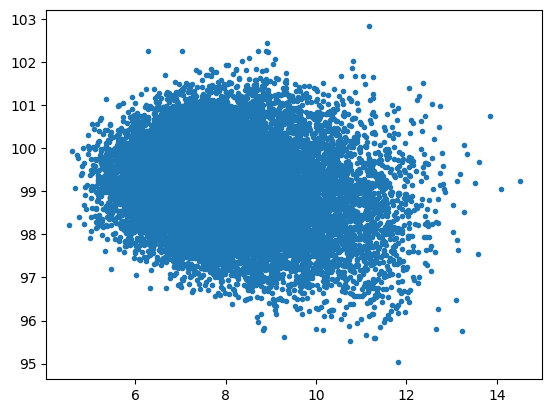

In [21]:
x_ = mahaClusterCenters[c0_indx,:]
plt.plot(x_[:,0], x_[:,1], '.')

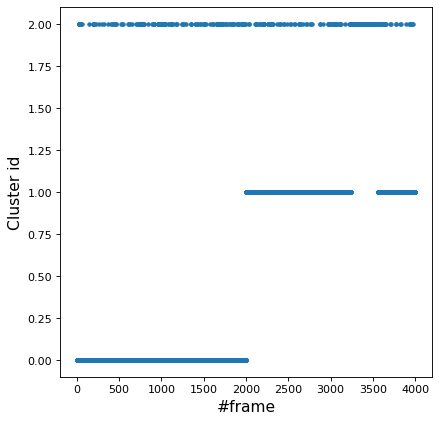

In [22]:
plt.figure(figsize=(6,6), dpi=80)
plt.ylabel("Cluster id", fontsize=14)
plt.xlabel("#frame", fontsize=14)
plt.plot(entire_traj_clusters[::10], '.')

In [23]:
print(trajData[20001::].shape)

(20001, 23, 3)


In [24]:
global_aligned_traj = np.load("global_aligned_traj.npy", allow_pickle=True)
print(global_aligned_traj.shape)

(40002, 23, 3)


In [25]:
clusters_assigned = np.concatenate([np.zeros(len(c0_indx)), np.ones(len(c1_indx))], axis=0)
print(clusters_assigned.shape)

(33851,)


## getting avg. prec for c=0 and c=1 and aligning the trajs 

In [26]:
# extracting only the frames belongign to c=0 and c=1
c0_frames = trajData[c0_indx]
c1_frames = trajData[c1_indx]

print(c0_frames.shape,'\n',c1_frames.shape)

(18222, 23, 3) 
 (15629, 23, 3)


In [33]:
from shapeGMM import _traj_tools as traj_tools

# align to left helix 
_, left_avg, left_precision, _ = traj_tools.traj_iterative_average_precision_weighted_kabsch(c0_frames)
left_aligned_traj = traj_tools.traj_align_weighted_kabsch(trajData, left_avg, left_precision)

#np.savetxt("left_avg.txt", left_avg)
#np.savetxt("left_precision.txt", left_precision)

# align to the right helix 

_, right_avg, right_precision, _ = traj_tools.traj_iterative_average_precision_weighted_kabsch(c1_frames)
right_aligned_traj = traj_tools.traj_align_weighted_kabsch(trajData, right_avg, right_precision)

#np.savetxt("right_avg.txt", right_avg)
#np.savetxt("right_precision.txt", right_precision)

## Do LDA using alignment to left helix 

In [34]:
# extracting the frames again ***** from aligned traj***** this time !!!
c0_frames = left_aligned_traj[c0_indx]
c1_frames = left_aligned_traj[c1_indx]

c0_c1_frames = np.concatenate([c0_frames, c1_frames], axis=0)
print(c0_c1_frames.shape)

(33851, 23, 3)


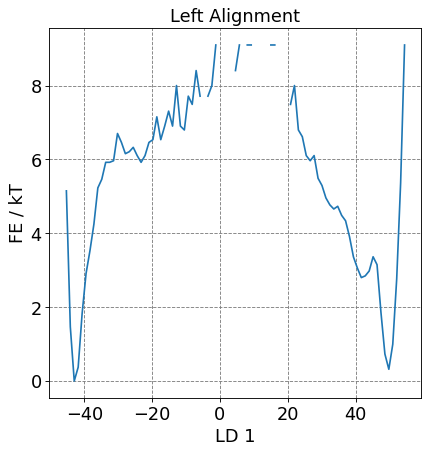

In [35]:
from matplotlib.collections import LineCollection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

ld_range = (-54,62)

nbins = 100

fig, axes =plt.subplots(1, 1, figsize=(6,6), dpi=80) 
#=========================================================================================#
# 00
axes.set_title("Left Alignment", fontsize=16)
axes.set_ylabel("FE / kT",fontsize=16)
axes.set_xlabel("LD 1", fontsize=16)
axes.tick_params(axis='both',labelsize=16)
axes.grid(which='major', axis='both', color='#808080', linestyle='--')

# lda calculation
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
lda.fit(c0_c1_frames.reshape(c0_c1_frames.shape[0], sel_backbone_101.n_atoms*3), clusters_assigned)
y_pred_sgmm3 = lda.transform(left_aligned_traj.reshape(left_aligned_traj.shape[0], sel_backbone_101.n_atoms*3))[:,0]


# histogramming the lda and calculate free energy
hist, bins = np.histogram(y_pred_sgmm3, range=ld_range, bins=nbins, density=True)

fe = -np.log(hist)
grids = (bins[:-1] + bins[1:])/2
axes.plot(grids, fe-fe.min())
#axes.plot(y_pred_sgmm3)

min = -45.69336044090164
max = 53.89317454934005
sigma = 3.029675730998032


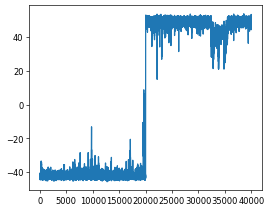

In [36]:
print("min =", min(y_pred_sgmm3))
print("max =", max(y_pred_sgmm3))
print("sigma =", np.std(y_pred_sgmm3[:20001:]))
#np.savetxt("ld1_scalings_left.txt", lda.scalings_[:,0])


plt.figure(figsize=(5,4), dpi=60)
plt.plot(y_pred_sgmm3)

[-43.93153241 -43.12791182 -42.84638326 -43.44363157 -42.92734728
 -42.92802437 -42.57955341 -44.12710139 -41.51563896 -42.70421844]


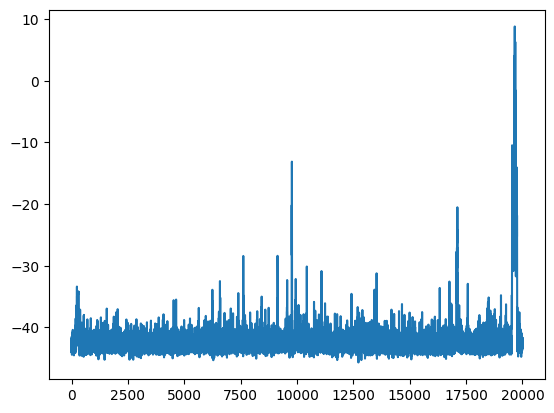

In [37]:
plt.plot(y_pred_sgmm3[:20001:])
print(y_pred_sgmm3[:10:])

In [38]:
x = np.loadtxt("../wt-metad_sim/SI_metad_sims_aib9/sec_S6_sims/left_aligned/ld_vals.txt", usecols=1)

x1 = np.loadtxt("../wt-metad_sim/SI_metad_sims_aib9/sec_S6_sims/left_aligned/ld_vals_right.txt", usecols=1)

In [39]:
print(min(x), max(x), np.std(x))
print(min(x1), max(x1), np.std(x1))

-3.12430417 51.37550585 3.0296757309946583
57.57170276 96.46223082 4.160651356703912


In [40]:
-1.36247614 + 43.93153241

42.569056270000004

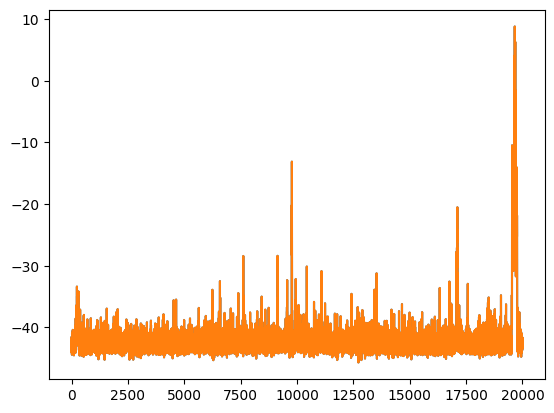

In [41]:
plt.plot(y_pred_sgmm3[:20001:])
y = x-42.569056270000004
plt.plot(y)

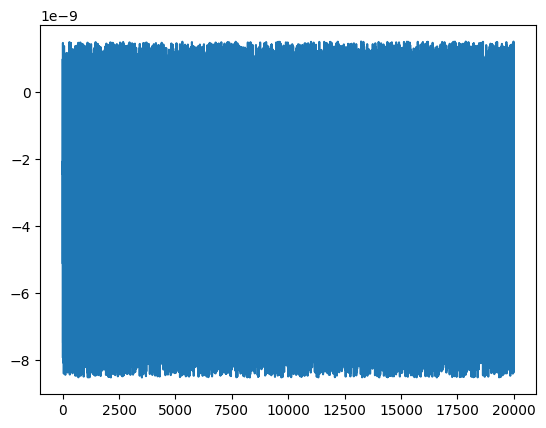

In [42]:
plt.plot(y-y_pred_sgmm3[:20001:])

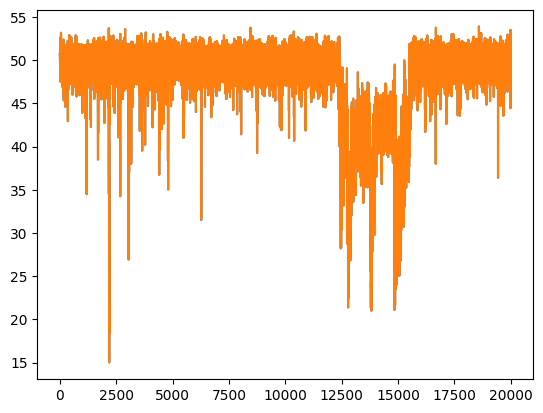

In [43]:
plt.plot(y_pred_sgmm3[20001::])
y1 = x1 - 42.569056270000004
plt.plot(y1)

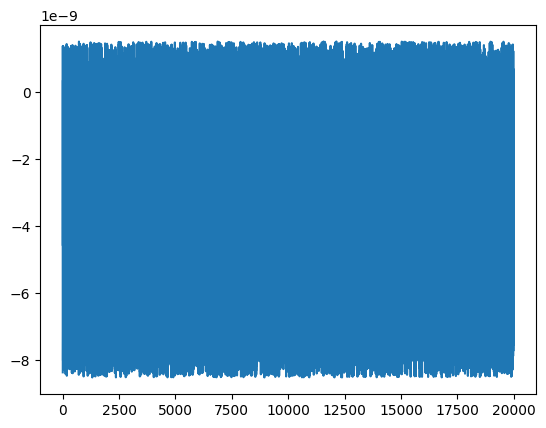

In [44]:
plt.plot(y1-y_pred_sgmm3[20001::])

## Do LDA using alignment to right helix

In [45]:
# extracting the frames again ***** from aligned traj***** this time !!!
c0_frames = right_aligned_traj[c0_indx]
c1_frames = right_aligned_traj[c1_indx]

c0_c1_frames = np.concatenate([c0_frames, c1_frames], axis=0)
print(c0_c1_frames.shape)

(33851, 23, 3)


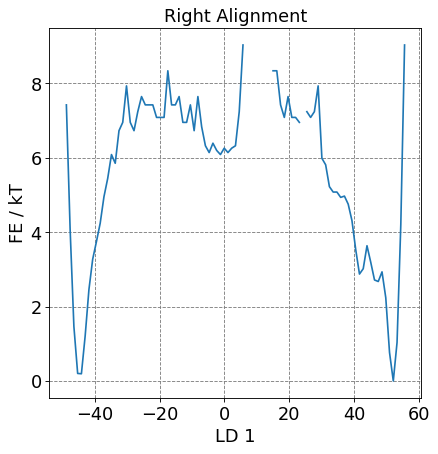

In [46]:
from matplotlib.collections import LineCollection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

ld_range = (-54,62)

nbins = 100

fig, axes =plt.subplots(1, 1, figsize=(6,6), dpi=80) 
#=========================================================================================#
# 00
axes.set_title("Right Alignment", fontsize=16)
axes.set_ylabel("FE / kT",fontsize=16)
axes.set_xlabel("LD 1", fontsize=16)
axes.tick_params(axis='both',labelsize=16)
axes.grid(which='major', axis='both', color='#808080', linestyle='--')

# lda calculation
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
lda.fit(c0_c1_frames.reshape(c0_c1_frames.shape[0], sel_backbone_101.n_atoms*3), clusters_assigned)
y_pred_sgmm3 = lda.transform(right_aligned_traj.reshape(right_aligned_traj.shape[0], sel_backbone_101.n_atoms*3))[:,0]


# histogramming the lda and calculate free energy
hist, bins = np.histogram(y_pred_sgmm3, range=ld_range, bins=nbins, density=True)

fe = -np.log(hist)
grids = (bins[:-1] + bins[1:])/2
axes.plot(grids, fe-fe.min())
#axes.plot(y_pred_sgmm3)

min = -48.578797190697536
max = 55.56558683187659
sigma = 4.660685356643419


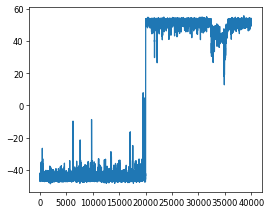

In [47]:
print("min =", min(y_pred_sgmm3))
print("max =", max(y_pred_sgmm3))
print("sigma =", np.std(y_pred_sgmm3[:20001:]))
#np.savetxt("ld1_scalings_right.txt", lda.scalings_[:,0])


plt.figure(figsize=(5,4), dpi=60)
plt.plot(y_pred_sgmm3)

In [49]:
zl = np.loadtxt("../wt-metad_sim/SI_metad_sims_aib9/sec_S6_sims/right_aligned/ld_vals.txt", usecols=1)

zr = np.loadtxt("../wt-metad_sim/SI_metad_sims_aib9/sec_S6_sims/right_aligned/ld_vals_right.txt", usecols=1)

In [50]:
print(min(zl), max(zl), np.std(zl))
print(min(zr), max(zr), np.std(zr))

-100.58823057 -44.15301438 4.660685356669298
-39.23699579 3.55615345 4.0544962795480055


In [51]:
print(y_pred_sgmm3[:10:])

[-46.20841311 -45.7411598  -44.0662246  -44.70042771 -46.13139633
 -44.98888167 -46.03319331 -44.81155286 -41.93099446 -44.43394115]


In [52]:
print(zl[:10:])

[-98.21784649 -97.75059317 -96.07565798 -96.70986109 -98.14082971
 -96.99831505 -98.04262669 -96.82098623 -93.94042784 -96.44337453]


In [53]:
-46.20841311+98.21784649

52.00943338

In [54]:
zl_mf = zl+52.00943338
zr_mf = zr+52.00943338

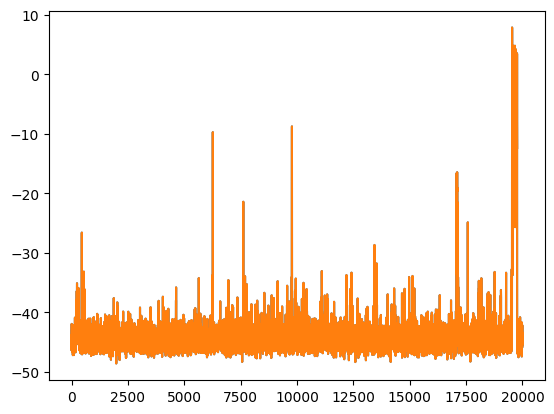

In [55]:
plt.plot(y_pred_sgmm3[:20001:])
plt.plot(zl_mf)

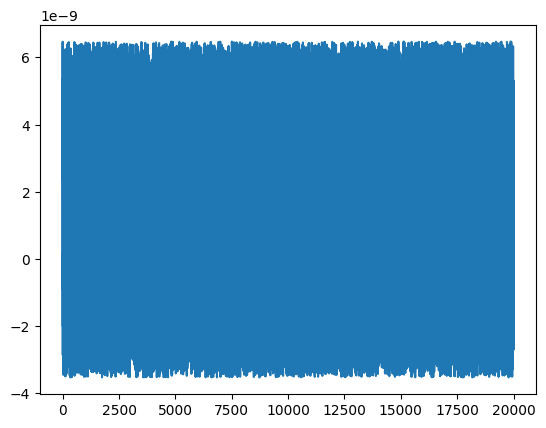

In [56]:
plt.plot(zl_mf - y_pred_sgmm3[:20001:])

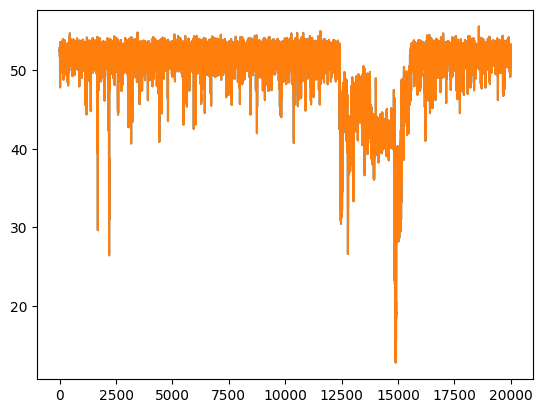

In [57]:
plt.plot(y_pred_sgmm3[20001::])
plt.plot(zr_mf)

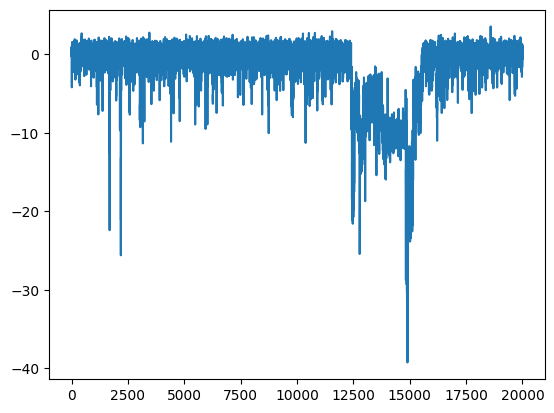

In [58]:
plt.plot(zr)

# LDA using global alignment (c=0 and c=1)

In [59]:
c0_frames = global_aligned_traj[c0_indx]
c1_frames = global_aligned_traj[c1_indx]

c0_c1_frames = np.concatenate([c0_frames, c1_frames], axis=0)
print(c0_c1_frames.shape)

(33851, 23, 3)


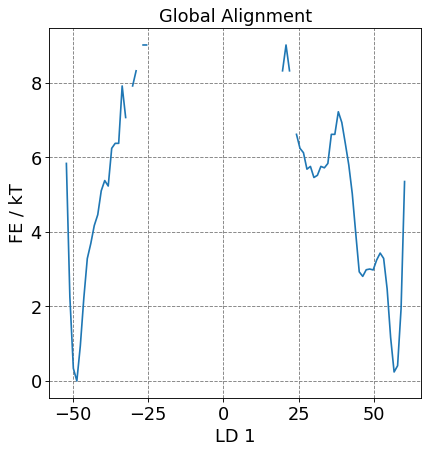

In [61]:
from matplotlib.collections import LineCollection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

ld_range = (-54,62)

nbins = 100

fig, axes =plt.subplots(1, 1, figsize=(6,6), dpi=80) 
#=========================================================================================#
# 00
axes.set_title("Global Alignment", fontsize=16)
axes.set_ylabel("FE / kT",fontsize=16)
axes.set_xlabel("LD 1", fontsize=16)
axes.tick_params(axis='both',labelsize=16)
axes.grid(which='major', axis='both', color='#808080', linestyle='--')

# lda calculation
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
lda.fit(c0_c1_frames.reshape(c0_c1_frames.shape[0], sel_backbone_101.n_atoms*3), clusters_assigned)
y_pred_sgmm3 = lda.transform(global_aligned_traj.reshape(global_aligned_traj.shape[0], sel_backbone_101.n_atoms*3))[:,0]

#y_pred_sgmm3 = lda.transform(entire_traj_traj.reshape(entire_traj_traj.shape[0], sel_backbone_101.n_atoms*3))[:,0]


# histogramming the lda and calculate free energy
hist, bins = np.histogram(y_pred_sgmm3, range=ld_range, bins=nbins, density=True)

fe = -np.log(hist)
grids = (bins[:-1] + bins[1:])/2
axes.plot(grids, fe-fe.min())

In [62]:
print(y_pred_sgmm3[:10:]-3.295396680000003)

[-53.42216166 -53.56754671 -51.75953361 -53.01355952 -52.57421058
 -52.35726247 -52.77004783 -52.47318775 -51.89530844 -51.56419611]


In [63]:
-50.12676498 + 53.42216166

3.295396680000003

(40002,)


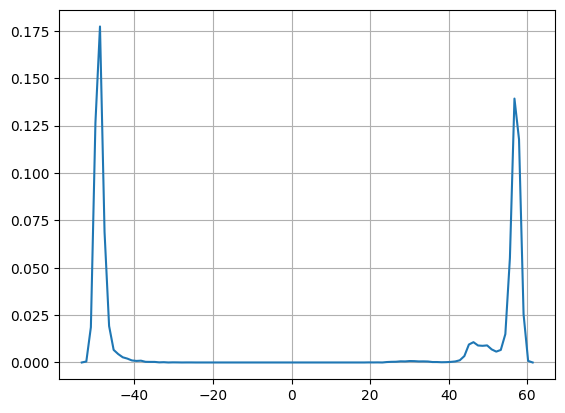

In [64]:
print(y_pred_sgmm3.shape)
plt.grid()
plt.plot(grids, hist)

In [65]:
a = np.std(y_pred_sgmm3[:20001:])
b = np.std(y_pred_sgmm3[20001::])
c = np.std(y_pred_sgmm3)

print(a,b)
print(c)

1.7361726351474371 4.636185158974684
52.07147908141353


In [66]:
print((a+b)/2)

3.186178897061061


In [23]:
#np.savetxt("fe_vs_ld1_sklearn.txt", np.array([grids, fe-fe.min()]).T)

In [67]:
print(min(y_pred_sgmm3), max(y_pred_sgmm3))

-52.60283368554957 60.80375550950278


In [28]:
# save lda.scalings_[:,0] for simulation
#np.savetxt("ld1_scalings.txt", lda.scalings_[:,0])

In [70]:
# save lda scalings 
print(wsgmm.precisions.shape)

(3, 23, 23)


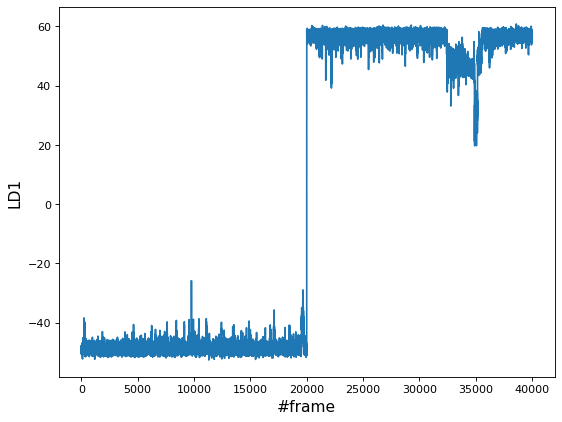

In [71]:
plt.figure(figsize=(8,6), dpi=80)
plt.xlabel("#frame", fontsize=14)
plt.ylabel("LD1", fontsize=14)
plt.plot(y_pred_sgmm3, '-')

In [30]:
out = np.array([np.arange(trajData.shape[0]), y_pred_sgmm3]).T
#np.savetxt("ld1_sklearn_data.txt", out)

40002


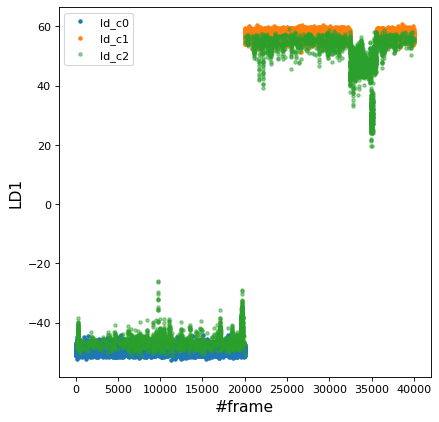

In [72]:
ld_c0 = y_pred_sgmm3[c0_indx]
ld_c1 = y_pred_sgmm3[c1_indx]
ld_c2 = y_pred_sgmm3[c2_indx]

time_c0 = np.arange(trajData.shape[0])[c0_indx]
time_c1 = np.arange(trajData.shape[0])[c1_indx]
time_c2 = np.arange(trajData.shape[0])[c2_indx]

print(len(time_c0)+len(time_c1)+len(time_c2))

plt.figure(figsize=(6,6), dpi=80)
plt.xlabel("#frame", fontsize=14)
plt.ylabel("LD1", fontsize=14)
plt.plot(time_c0, ld_c0, '.', label="ld_c0")
plt.plot(time_c1, ld_c1, '.', label="ld_c1")
plt.plot(time_c2, ld_c2, '.', alpha=0.5, label="ld_c2")
plt.legend()

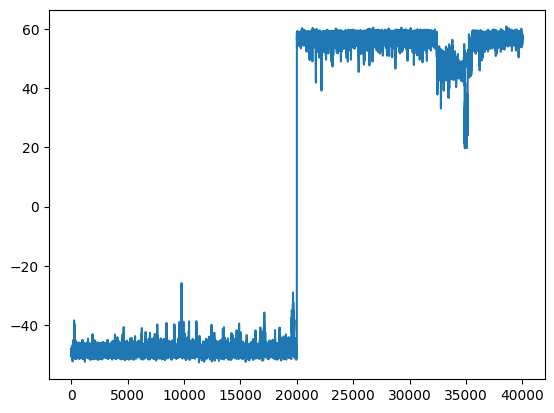

In [73]:
data = []
for i in range(global_aligned_traj.shape[0]):
    val = np.dot(global_aligned_traj[i,:,:].flatten()-lda.xbar_, lda.scalings_[:,0])
    data.append(val)
plt.plot(data)

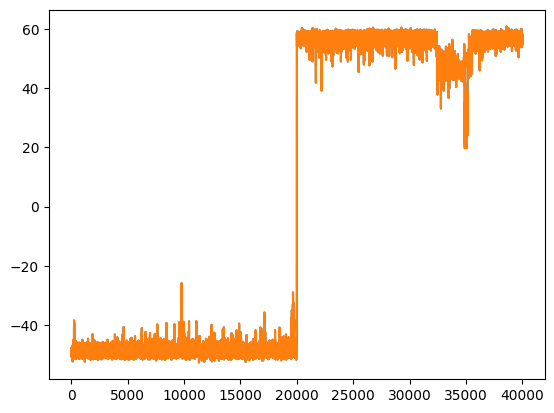

In [74]:
plt.plot(data)
plt.plot(y_pred_sgmm3)

In [75]:
print(sel_backbone_101.indices)

[ 17  19  21  30  32  34  43  45  47  56  58  60  69  71  73  82  84  86
  95  97  99 108 110]


# LDA using all states

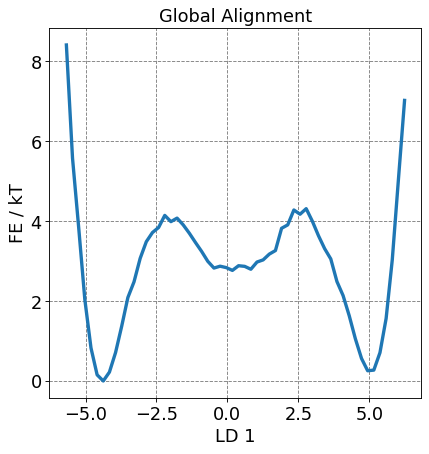

In [77]:
from matplotlib.collections import LineCollection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

ld_range = (-6,7)

nbins = 60

fig, axes =plt.subplots(1, 1, figsize=(6,6), dpi=80) 
#=========================================================================================#
# 00
axes.set_title("Global Alignment", fontsize=16)
axes.set_ylabel("FE / kT",fontsize=16)
axes.set_xlabel("LD 1", fontsize=16)
axes.tick_params(axis='both',labelsize=16)
axes.grid(which='major', axis='both', color='#808080', linestyle='--')

# lda calculation
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
lda.fit(global_aligned_traj.reshape(global_aligned_traj.shape[0], sel_backbone_101.n_atoms*3), entire_traj_clusters)
ld1_all = lda.transform(global_aligned_traj.reshape(global_aligned_traj.shape[0], sel_backbone_101.n_atoms*3))[:,0]

#ld1_all = lda.fit_transform(global_aligned_traj.reshape(global_aligned_traj.shape[0], sel_backbone_101.n_atoms*3), entire_traj_clusters)[:,0]


# histogramming the lda and calculate free energy
hist, bins = np.histogram(ld1_all, range=ld_range, bins=nbins, density=True)

fe = -np.log(hist)
grids = (bins[:-1] + bins[1:])/2
axes.plot(grids, fe-fe.min(), lw=3.0)

In [78]:
print(ld1_all.min(), ld1_all.max())

-5.676430301813478 6.245650364206764


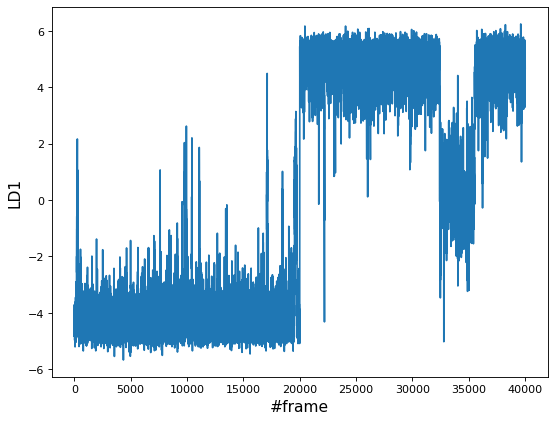

In [79]:
plt.figure(figsize=(8,6), dpi=80)
plt.xlabel("#frame", fontsize=14)
plt.ylabel("LD1", fontsize=14)
plt.plot(ld1_all, '-')

40002


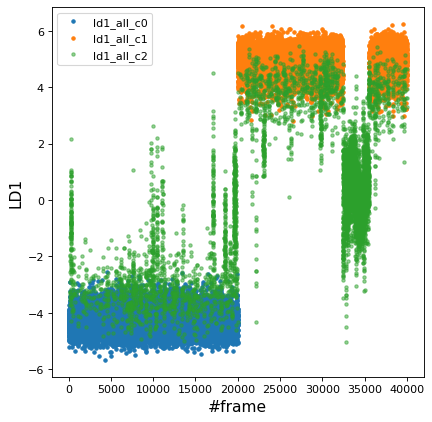

In [80]:
ld1_all_c0 = ld1_all[c0_indx]
ld1_all_c1 = ld1_all[c1_indx]
ld1_all_c2 = ld1_all[c2_indx]

time_c0 = np.arange(trajData.shape[0])[c0_indx]
time_c1 = np.arange(trajData.shape[0])[c1_indx]
time_c2 = np.arange(trajData.shape[0])[c2_indx]

print(len(time_c0)+len(time_c1)+len(time_c2))

plt.figure(figsize=(6,6), dpi=80)
plt.xlabel("#frame", fontsize=14)
plt.ylabel("LD1", fontsize=14)
plt.plot(time_c0, ld1_all_c0, '.', label="ld1_all_c0")
plt.plot(time_c1, ld1_all_c1, '.', label="ld1_all_c1")
plt.plot(time_c2, ld1_all_c2, '.', alpha=0.5, label="ld1_all_c2")
plt.legend()

In [81]:
print("hello")

hello


# PCA using aligned atomic positions on AIB9

In [82]:
print(global_aligned_traj.shape)
print(len(sel_backbone_101))

(40002, 23, 3)
23


In [83]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, svd_solver="full")
pcs = pca.fit_transform(global_aligned_traj.reshape(global_aligned_traj.shape[0], global_aligned_traj.shape[1]*3))

In [84]:
print(pca.n_samples_)
print(pca.n_features_)
print(pca.explained_variance_)
print(pca.n_components_)
print(pca.components_.shape)
print(pca.noise_variance_)

40002
69
[34.83433786  4.26311846]
2
(2, 69)
0.13713539570024347


In [85]:
pc1_std = np.std(pcs[:,0])
pc1_std_left = np.std(pcs[:,0][:20001:])
pc1_std_right = np.std(pcs[:,0][20001::])

print(pc1_std)
print(pc1_std_left)
print(pc1_std_right)

5.901988397756334
0.48048676075517244
0.55205101232531


In [101]:
#np.savetxt("pc1_coeffs.txt", pca.components_[0,:])

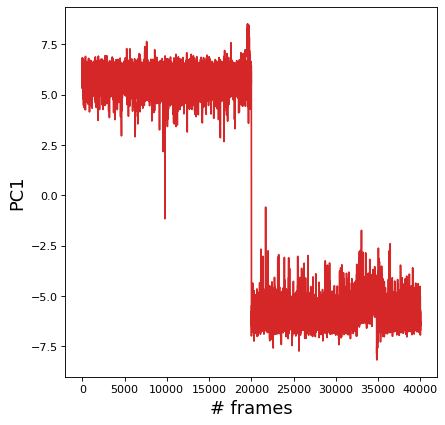

In [86]:
plt.figure(figsize=(6,6), dpi=80)
plt.ylabel("PC1", fontsize=16)
plt.xlabel("# frames", fontsize=16)
plt.plot(pcs[:,0], '-', color="tab:red")

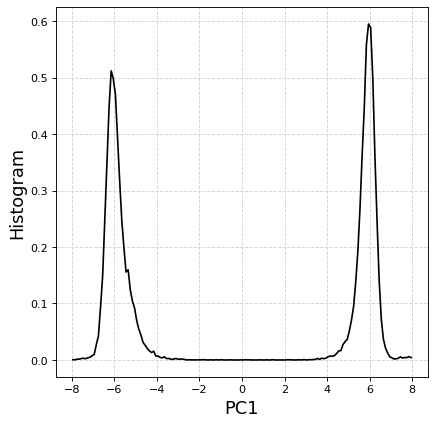

In [87]:
plt.figure(figsize=(6,6), dpi=80)
plt.xlabel("PC1", fontsize=16)
plt.ylabel("Histogram", fontsize=16)
plt.grid(axis="both", which="major", linestyle="--", color="lightgrey")
hist, bins = np.histogram(pcs[:,0], bins=160, range=[-8,8], density=True)
grids = (bins[:-1] + bins[1:])/2.0
plt.plot(grids, hist, 'k-')

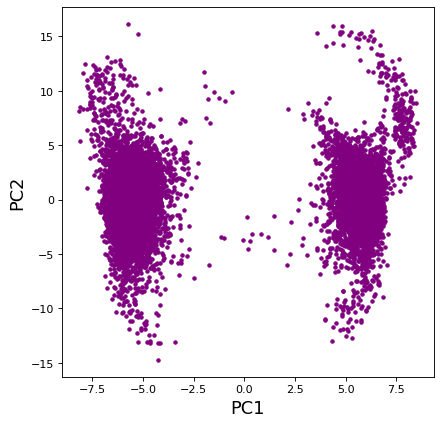

In [88]:
plt.figure(figsize=(6,6), dpi=80)
plt.xlabel("PC1", fontsize=16)
plt.ylabel("PC2", fontsize=16)
plt.scatter(pcs[:,0], pcs[:,1], marker='.', color="purple")

In [89]:
np.sum(np.matmul(global_aligned_traj[1,:,:].reshape(69), pca.components_[0,:]))

6.277594115203055

In [90]:
pcs[:,0][1]

6.252799129540086